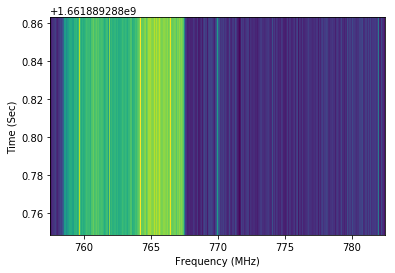

In [5]:
import numpy as n
import uhd
import scipy.signal as ss
import time
import matplotlib.pyplot as plt
import h5py

def acquire_spectrum(freq=770e6,
                     sample_rate=25e6,
                     n_fft=1024,
                     n_avg=64,
                     n_t=2,
                     subdev="A:A",
                     ofname="spectrogram1.h5"):

    usrp = uhd.usrp.MultiUSRP("recv_buff_size=500000000")
    subdev_spec=uhd.usrp.SubdevSpec(subdev)
    usrp.set_rx_subdev_spec(subdev_spec)

    plt.ion()
    fig = plt.figure()
    ax=fig.add_subplot(111)
    
    for i in range(100):
        w=ss.blackmanharris(n_fft)
        freqv=n.fft.fftshift(n.fft.fftfreq(n_fft, d=1.0/25e6))+freq
        S=n.zeros([n_t, n_fft])
        tvec=[]
        for ti in range(n_t):
            #print("%d/%d" % (ti, n_t))
            samps = usrp.recv_num_samps(n_fft*n_avg, freq, 25000000, [0], 0)
            tvec.append(time.time())
            if len(samps[0]) != n_fft*n_avg:
                print("error")
            else:
                z=samps[0]
                z=z-n.mean(z)
                for ai in range(n_avg):
                    S[ti, :]+=n.abs(n.fft.fftshift(
                    n.fft.fft(z[(ai*n_fft):(ai*n_fft + n_fft)]*w)))**2.0

        tvec=n.array(tvec)
        
        with h5py.File("spec-%d.h5" % (time.time()), "w") as ho:
            ho["S"]=S
            ho["tvec"]=tvec
            ho["fvec"]=freqv

        
    ax.clear()
    ax.pcolormesh(freqv/1e6, tvec, 10.0*n.log10(S))
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Time (Sec)")
    fig.canvas.draw()
    fig.canvas.flush_events()


if __name__ == "__main__":
    acquire_spectrum()

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

class data:
    
    spectrum=np.zeros(0)
    frequency=np.zeros(0)
    time=np.zeros(0)

    def plot_spectrum(name='spectrogram1.h5'):


        with h5py.File(name,'r') as h:
            ls = list(h.keys())
            print('List of Datasets in this file are: \n', ls)
            freqv = h.get('fvec')
            S = h.get('S')
            tvec= h.get["tvec"]
            freqv = np.array(freqv)
            S = np.array(S)
            tvec= np.array(tvec)
            np.append(spectrum,S)
            np.append(frequency,freqv)
            np.append(time,tvec)

    def plot(spectrum,frequency):
        
            plt.pcolormesh(freqv/1e6, tvec, 10.0*n.log10(S))
            plt.set_xlabel("Frequency (MHz)")
            plt.set_ylabel("Time (unix)")
            fig.canvas.draw()
            fig.canvas.flush_events()